In [1]:
from collections import Counter, deque, defaultdict
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import community as community_louvain


from Project.utils.storage import truth_db as t_db
from Project.utils.storage import bluesky_db as b_db

importlib.reload(t_db)
importlib.reload(b_db)

truth_db = t_db.SQLiteTruthSaver(db_name='db/truthsocial.db')
bluesky_db = b_db.SQLiteBlueSkySaver(db_name='db/bluesky.db')

## 0. Extracting Graphs and Subgraphs

In [2]:
# Truth_Graph = truth_db.extract_network()
# nx.write_gexf(Truth_Graph, "truth.gexf")
#
# Bluesky_Graph = bluesky_db.extract_network()
# nx.write_gexf(Bluesky_Graph, "bluesky.gexf")
#
# Truth_TopGraph = SQLiteTruthSaver().extract_network(top_k=1000)
# nx.write_gexf(Truth_TopGraph, "truth_top1000.gexf")
#
# Bluesky_TopGraph = SQLiteBlueSkySaver().extract_network(top_k=1000)
# nx.write_gexf(Bluesky_TopGraph, "bluesky_top1000.gexf")
#
# Truth_Graph = nx.read_gexf("truth.gexf")
# Bluesky_Graph = nx.read_gexf("bluesky.gexf")
# Truth_TopGraph = nx.read_gexf("truth_top1000.gexf")
# Bluesky_TopGraph = nx.read_gexf("bluesky_top1000.gexf")

Bluesky_G = nx.read_gexf("bluesky.gexf")
Truth_G = nx.read_gexf("truth_sub.gexf")

## 1. Basic Measures

Order, Size, Degree Distribution and Connected Components

In [30]:
def gini_coeff(x):
    x = np.sort(np.array(x))
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def analyze_graph(G, color):
    print(f"{G.order()} Nodes and {G.size()} Edges")
    print(f"Density is {nx.density(G)}")

    degree = dict(G.degree())
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    degree_values = list(degree.values())
    in_degree_values = list(in_degree.values())
    out_degree_values = list(out_degree.values())

    # Calculate Lorenz Curve for the Distribution of Posts between Users
    posts_count_dict = np.sort([
        node['posts_count']
        for node_id, node in G.nodes(data=True)
    ])
    posts_count_cdf = np.cumsum(posts_count_dict) / sum(posts_count_dict)
    lam = nx.density(G) * (G.order() - 1)
    poisson_posts_count = np.sort(np.random.poisson(lam=lam, size=len(posts_count_dict)))
    poisson_posts_count_cdf = np.cumsum(poisson_posts_count) / sum(poisson_posts_count)


    count, bins = np.histogram(
        in_degree_values,
        bins=np.arange(0, max(in_degree_values) + 2)
    )
    pdf = count / G.order()
    ccdf = 1.0 - np.cumsum(pdf)

    ccdf[-1] = 0.0 # Fixes floating point error

    print(f"Nodes with in degree zero: {len([x for x in in_degree_values if x == 0])}")

    # Compute connected component sizes
    cc = list(nx.weakly_connected_components(G))
    component_sizes = sorted([len(c) for c in cc], reverse=True)
    components_by_size = Counter(component_sizes)

    # Print stats
    print(f"Min Degree: {min(degree_values)}")
    print(f"Max Degree: {max(degree_values)}")
    print(f"Average Degree: {np.mean(degree_values):.2f}")
    print(f"Average In-Degree: {np.mean(in_degree_values):.2f}")
    print(f"Average Out-Degree: {np.mean(out_degree_values):.2f}")

    print(f"There are {len(cc)} Connected Components:")
    for component in cc[:min(3, len(cc))]:
        print(f"\tConnected Component of size: {len(component)} ({len(component)/G.order():.2%})")
    print("\t...")

    top_in = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by In-Degree:")
    for node, deg in top_in:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: In-Degree = {deg}")

    top_out = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Out-Degree:")
    for node, deg in top_out:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Out-Degree = {deg}")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    top_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Degree Centrality:")
    for node, centrality in top_deg_centrality:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Degree Centrality = {centrality:.4f}")


    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], pdf, marker='o', linestyle='--', label="Degree PDF", color=color)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.title("In-Degree PDF")
    plt.xlabel("Degree")
    plt.ylabel("PDF - P(X=x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], ccdf, marker='o', linestyle='--', label="Degree CCDF", color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("In-Degree CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF - P(X>x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.scatter(np.arange(len(posts_count_cdf)) / (len(posts_count_dict) - 1), posts_count_cdf, marker='o', linestyle='--', label="Network", color=color)
    plt.scatter(np.arange(len(poisson_posts_count_cdf)) / (len(poisson_posts_count) - 1), poisson_posts_count_cdf, marker='o', linestyle='--', label="Erdos-Renyi Random Network", color="gray")
    plt.plot([0, 1], [0, 1], 'k--', label="Equality Line")
    plt.title("Lorenz Curve of Posts per User")
    plt.xlabel("Cum. % of Users")
    plt.ylabel("Cum. % of Posts")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Gini Coefficient: {gini_coeff(posts_count_dict):.5f}")

    plt.figure(figsize=(7, 4))
    plt.scatter(list(components_by_size.keys()), list(components_by_size.values()), color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Weakly Connected Components")
    plt.xlabel("Component Size")
    plt.ylabel("# of Components")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(list(deg_centrality.values()), bins=50, log=True, color=color, alpha=0.7)
    plt.title("Distribuzione Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


In [ ]:
#analyze_graph(Truth_Graph, color='red')

In [ ]:
#analyze_graph(Bluesky_Graph, color='blue')

In [ ]:
#analyze_graph(Truth_TopGraph, color='coral')

In [ ]:
#analyze_graph(Bluesky_TopGraph, color='royalblue')

In [27]:
def bidirectional_forest_fire_sample(G, max_nodes, seed_node=None, p_forward=0.7):
    """Compared to traditional Forest Fire Sampling, the neighbors selected for burning can either be at the end of out-links or in-links"""
    if seed_node is None:
        seed_node = random.choice(list(G.nodes))

    sampled_nodes = {seed_node}
    queue = [seed_node]

    while queue and len(sampled_nodes) < max_nodes:
        current = queue.pop(0)

        # Combine outgoing and incoming edges
        try:
            neighbors = set(G.successors(current)) | set(G.predecessors(current))
        except:
            neighbors = set(G.neighbors(current))  # Fallback for undirected

        neighbors -= sampled_nodes
        if not neighbors:
            continue

        # Burn a random number of neighbors (at least 1 if possible)
        burn_count = max(1, int(len(neighbors) * p_forward))
        burn_count = min(burn_count, len(neighbors))  # Avoid overflow

        neighbors = list(neighbors)
        random.shuffle(neighbors)
        for neighbor in neighbors[:burn_count]:
            if neighbor not in sampled_nodes:
                sampled_nodes.add(neighbor)
                queue.append(neighbor)
                if len(sampled_nodes) >= max_nodes:
                    break

    return G.subgraph(sampled_nodes).copy()

In [28]:
#Truth_Subgraph = bidirectional_forest_fire_sample(Truth_Graph, max_nodes=len(Bluesky_Graph.nodes()))

In [ ]:
#analyze_graph(Truth_Subgraph, color='coral')

In [32]:
#nx.write_gexf(Truth_Subgraph, "truth_sub.gexf")

In [ ]:
# So the graphs are:

# bluesky.gexf (14k nodes, 17k edges)
# truth_sub.gexf (14k nodes, 29k edges) - obtained with forest fire sampling

# Now Echo Chambers via:
# - Stance Assortativity (facile)
# - Neighbourhood Leaning (medio)
# - Community Homophily (medio)
# - Information Difussion Simulation (SIR) (difficile)

# Per poterlo fare, prima conviene calcolare la stance e metterla come attributo dei nodi


In [34]:
Truth_G.order(), Truth_G.size()

(14748, 30556)

In [35]:
Bluesky_G.order(), Bluesky_G.size()

(14748, 17623)

14748 Nodes and 30556 Edges
Density is 0.00014049461940919834
Nodes with in degree zero: 10959
Min Degree: 1
Max Degree: 10119
Average Degree: 4.14
Average In-Degree: 2.07
Average Out-Degree: 2.07
There are 1 Connected Components:
	Connected Component of size: 14748 (100.00%)
	...
Top 3 Nodes by In-Degree:
	Node realDonaldTrump https://truthsocial.com/@realDonaldTrump: In-Degree = 10119
	Node joemccuiston https://truthsocial.com/@joemccuiston: In-Degree = 1100
	Node OAN https://truthsocial.com/@OAN: In-Degree = 1062
Top 3 Nodes by Out-Degree:
	Node DaKine17 https://truthsocial.com/@DaKine17: Out-Degree = 539
	Node char_smi3 https://truthsocial.com/@char_smi3: Out-Degree = 98
	Node Yatti420 https://truthsocial.com/@Yatti420: Out-Degree = 54
Top 3 Nodes by Degree Centrality:
	Node realDonaldTrump https://truthsocial.com/@realDonaldTrump: Degree Centrality = 0.6862
	Node joemccuiston https://truthsocial.com/@joemccuiston: Degree Centrality = 0.0749
	Node OAN https://truthsocial.com/@OAN: 

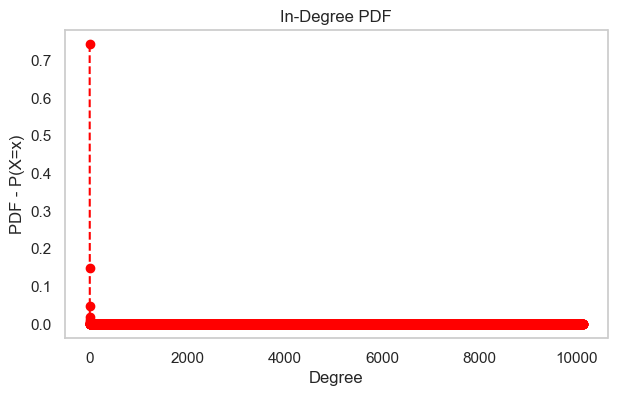

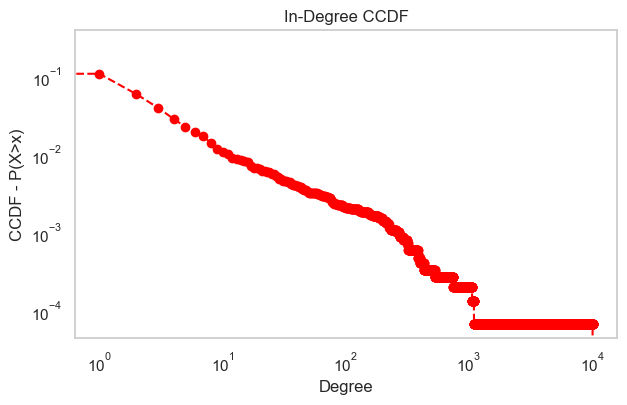

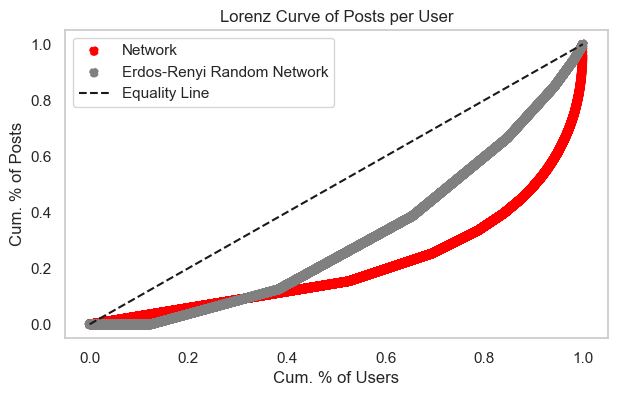

Gini Coefficient: 0.57612


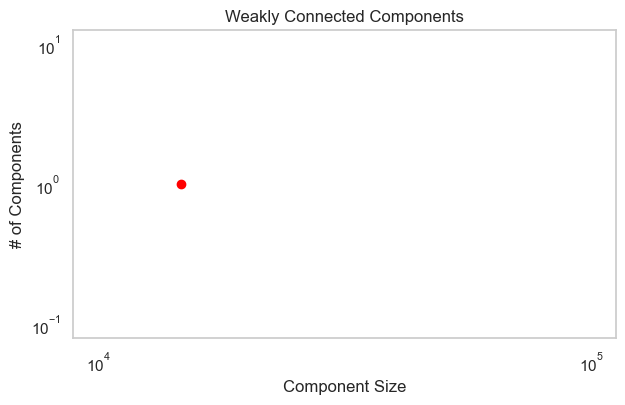

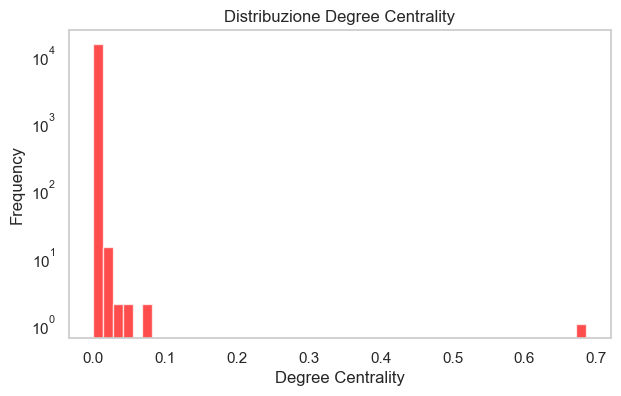

In [139]:
analyze_graph(Truth_G, color='red')

14748 Nodes and 17623 Edges
Density is 8.10294763008346e-05
Nodes with in degree zero: 13953
Min Degree: 1
Max Degree: 1149
Average Degree: 2.39
Average In-Degree: 1.19
Average Out-Degree: 1.19
There are 246 Connected Components:
	Connected Component of size: 13960 (94.66%)
	Connected Component of size: 8 (0.05%)
	Connected Component of size: 7 (0.05%)
	...
Top 3 Nodes by In-Degree:
	Node atrupar.com https://bsky.app/profile/atrupar.com: In-Degree = 1149
	Node mollyjongfast.bsky.social https://bsky.app/profile/mollyjongfast.bsky.social: In-Degree = 817
	Node artcandee.bsky.social https://bsky.app/profile/artcandee.bsky.social: In-Degree = 778
Top 3 Nodes by Out-Degree:
	Node mccarthypm.bsky.social https://bsky.app/profile/mccarthypm.bsky.social: Out-Degree = 22
	Node robertomitchelli.bsky.social https://bsky.app/profile/robertomitchelli.bsky.social: Out-Degree = 17
	Node nameless62.bsky.social https://bsky.app/profile/nameless62.bsky.social: Out-Degree = 17
Top 3 Nodes by Degree Centra

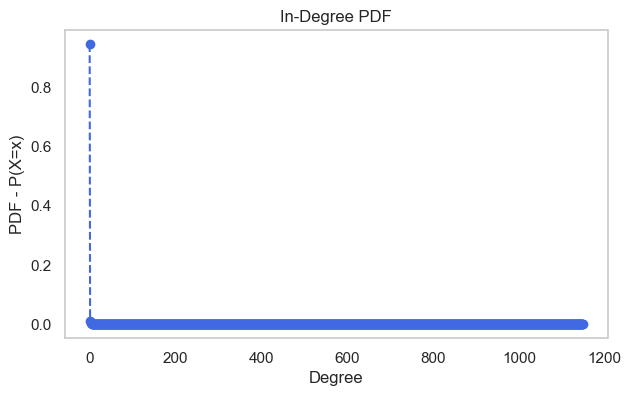

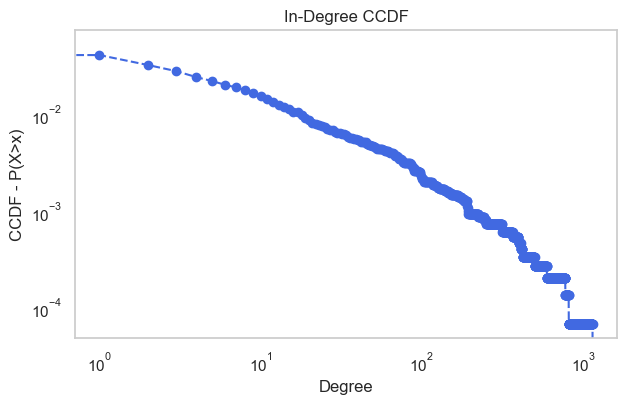

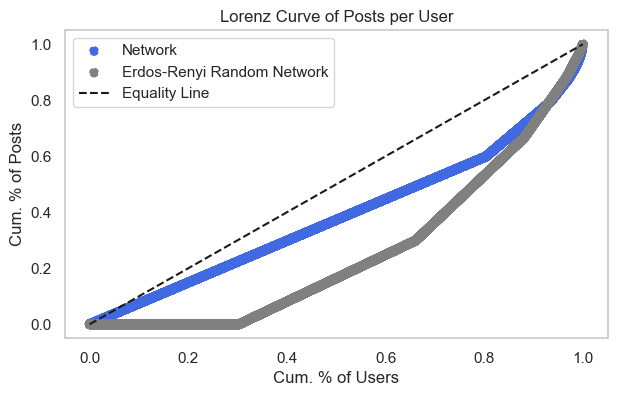

Gini Coefficient: 0.22139


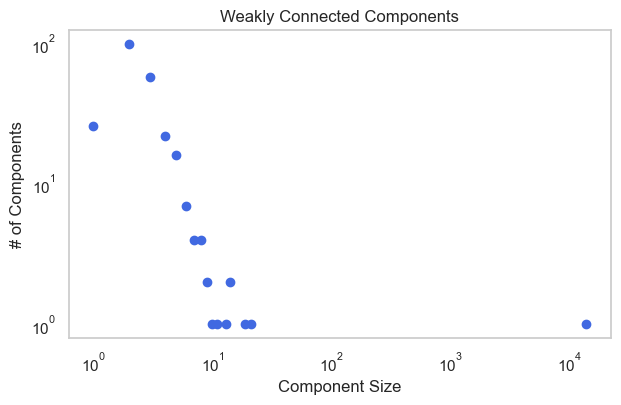

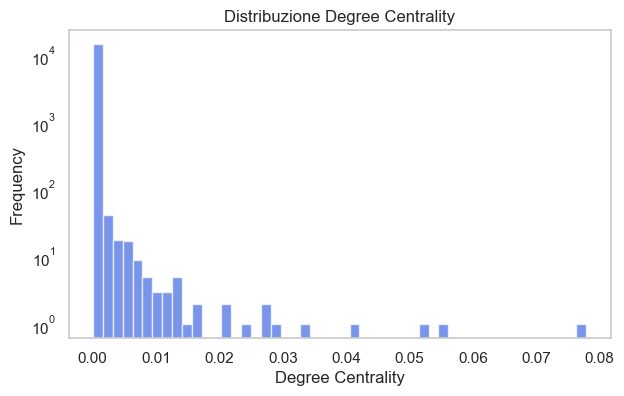

In [140]:
analyze_graph(Bluesky_G, color='royalblue')

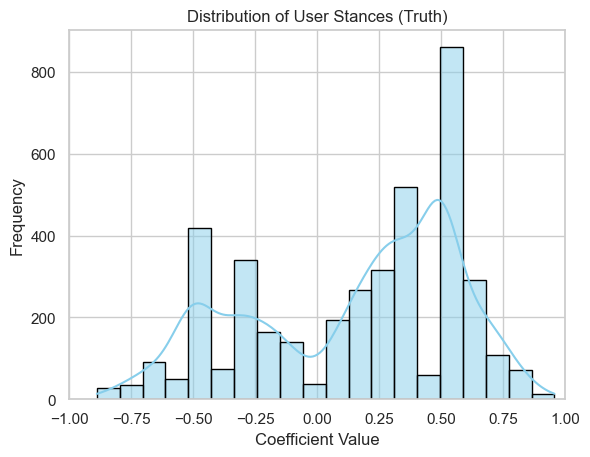

In [99]:
truth_nodes = {
    node: attrs
    for node, attrs in Truth_G.nodes(data=True)
    if attrs['average_stance'] not in [0, 1, -1] # These values usually mean not enough data
}

truth_stances = [
    attrs['average_stance'] for node, attrs in truth_nodes.items()
]

# Set the plot style
sns.set(style='whitegrid')

# Create histogram + KDE
sns.histplot(truth_stances, bins=20, kde=True, color='skyblue', edgecolor='black')

# Add labels and limits
plt.title('Distribution of User Stances (Truth)')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.xlim(-1, 1)

plt.show()

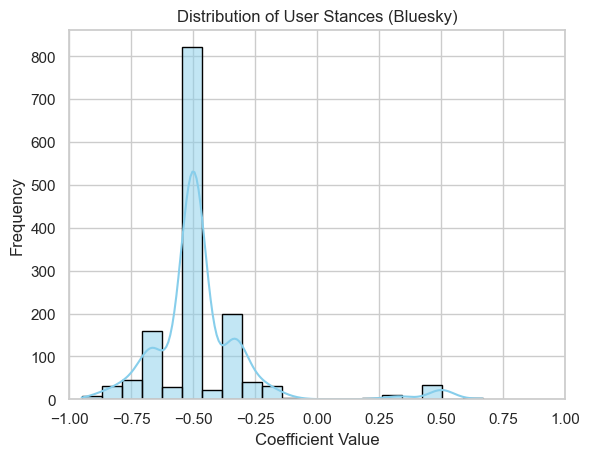

In [98]:
bluesky_nodes = {
    node: attrs
    for node, attrs in Bluesky_G.nodes(data=True)
    if attrs['average_stance'] not in [0, 1, -1] # These values usually mean not enough data
}

bluesky_stances = [
    attrs['average_stance'] for _, attrs in bluesky_nodes.items()
]

# Set the plot style
sns.set(style='whitegrid')

# Create histogram + KDE
sns.histplot(bluesky_stances, bins=20, kde=True, color='skyblue', edgecolor='black')

# Add labels and limits
plt.title('Distribution of User Stances (Bluesky)')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.xlim(-1, 1)

plt.show()

In [56]:
# Assortativities

truth_assort = nx.numeric_assortativity_coefficient(Truth_G, attribute='average_stance') # Very weak
bluesky_assort = nx.numeric_assortativity_coefficient(Bluesky_G, attribute='average_stance') # Very weak

print(truth_assort, bluesky_assort)

0.07914508300361561 0.07548975804329566


In [ ]:
Truth_G.nodes()

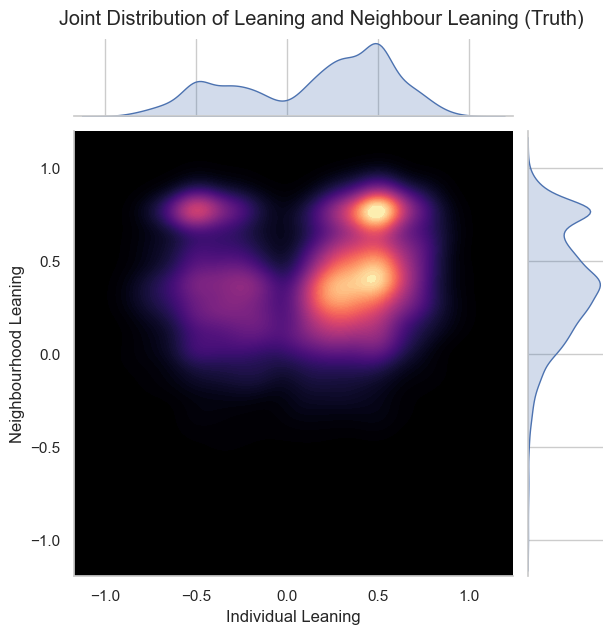

In [137]:
# Neighbourhood Leaning

def neighbour_stance(G, n):
    return np.average([
        G.nodes(data=True)[neighbour_id]['average_stance']
        for neighbour_id in nx.all_neighbors(G, n)
    ])

neighbour_truth_stances = [
    float(neighbour_stance(Truth_G, n)) for n, _ in truth_nodes.items()
]

g = sns.jointplot(
    x=truth_stances,
    y=neighbour_truth_stances,
    kind="kde",
    fill=True,
    cmap="magma",
    bw_adjust=0.9,
    thresh=0.01,
    levels=100,
    marginal_kws=dict(fill=True),
)

g.ax_joint.grid(False)
g.ax_joint.set_facecolor("black")
g.ax_joint.set_xlabel("Individual Leaning")
g.ax_joint.set_ylabel("Neighbourhood Leaning")

g.fig.suptitle("Joint Distribution of Leaning and Neighbour Leaning (Truth)", y=1.02)
plt.show()

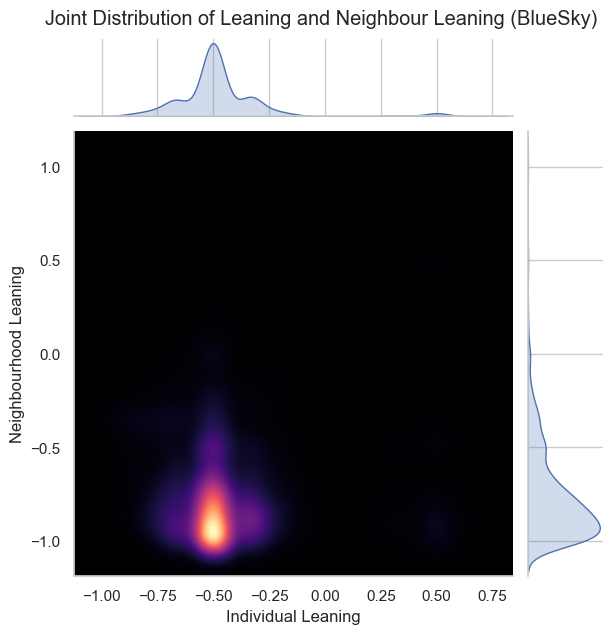

In [138]:
# Neighbourhood Leaning

neighbour_bluesky_stances = [
    float(neighbour_stance(Bluesky_G, n)) for n, _ in bluesky_nodes.items()
]

g = sns.jointplot(
    x=bluesky_stances,
    y=neighbour_bluesky_stances,
    kind="kde",
    fill=True,
    cmap="magma",
    bw_adjust=0.9,
    thresh=0.01,
    levels=100,
    marginal_kws=dict(fill=True),
)

g.ax_joint.grid(False)
g.ax_joint.set_facecolor("black")
g.ax_joint.set_xlabel("Individual Leaning")
g.ax_joint.set_ylabel("Neighbourhood Leaning")

g.fig.suptitle("Joint Distribution of Leaning and Neighbour Leaning (BlueSky)", y=1.02)
plt.show()

In [199]:
def print_communities_stance_histogram(
        sizes,
        stances
):
    ids = list(sizes.keys())
    y = [sizes[id] for id in ids]
    stance_values = np.array([stances[id] for id in ids])

    norm = colors.Normalize(vmin=-1, vmax=1)

    # Define the boundaries of your bins (edges of intervals)
    bounds = [-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0]

    # Define the discrete colors for each bin (8 bins -> 8 colors)
    colors_list = [
        '#0000cc',  # dark blue (x = -1 to -0.75)
        '#3366ff',  # medium blue
        '#99ccff',  # light blue
        '#cce6ff',  # very light blue
        '#ffe6e6',  # very light red / pinkish
        '#ff9999',  # light red
        '#ff4d4d',  # medium red
        '#cc0000'   # dark red (x = 0.75 to 1)
    ]

    # Create colormap and norm
    cmap = colors.ListedColormap(colors_list)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    bar_colors = cmap(norm(stance_values))

    fig, ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(ids, y, color=bar_colors)

    ax.set_xlabel('ID')
    ax.set_ylabel('Size')
    ax.set_title('Sizes colored by Stance (Red to Blue)')

    # Pass ax to colorbar to avoid ValueError
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed for colorbar

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Stance (-1 to 1)')

    plt.show()

Communities: 15


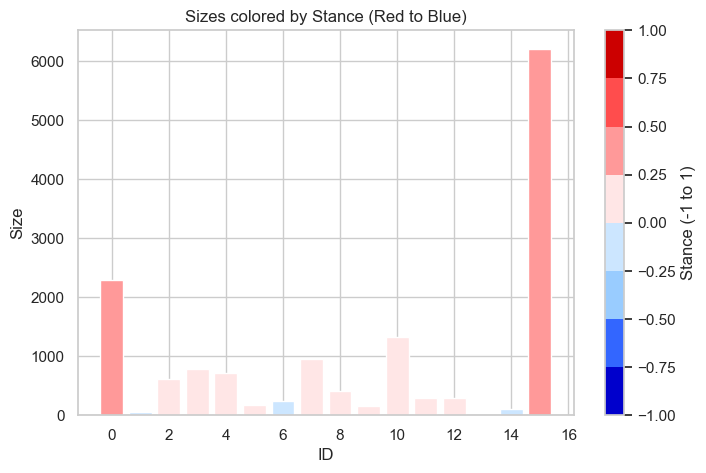

In [206]:
# Community Homophily

partition_truth = community_louvain.best_partition(
    Truth_G.to_undirected(),
    resolution=1.0
)

community_ids_truth = set(partition_truth.values())

communities_truth = {
    community_id: {
        node: Truth_G.nodes(data=True)[node] for node, comm in partition_truth.items()
        if comm == community_id
    }
    for community_id in community_ids_truth
}

communities_truth = {
    community_id: nodes
    for community_id, nodes in communities_truth.items()
    if len(nodes) > 50
}

communities_truth_sizes = {
    community_id: len(nodes)
    for community_id, nodes in communities_truth.items()
}

print(f"Communities: {len(communities_truth)}")

communities_leanings_truth = {
    community_id: np.average(
        a=[n['average_stance'] for _, n in nodes.items()],
        weights=[n['posts_count'] for _, n in nodes.items()]
    )
    for community_id, nodes in communities_truth.items()
}

print_communities_stance_histogram(
    communities_truth_sizes,
    communities_leanings_truth
)

In [208]:
# What are those blue communities ????

comm_6 = communities_truth[6]

comm_6 # Ci ha preso veramente:

# Guardare:
# https://truthsocial.com/@NJC802
# https://truthsocial.com/@Faketriots
# https://truthsocial.com/@Lmao_at_trumps_spelling

{'108783594593870400': {'username': 'GNorberg',
  'display_name': 'Ewegot',
  'url': 'https://truthsocial.com/@GNorberg',
  'posts_count': 13,
  'average_stance': 0.23076923076923078,
  'label': '108783594593870400'},
 '107864384110055008': {'username': 'KennedyBohanon',
  'display_name': 'OnTheBuckle MAGA🇺🇸BrutalAmerican',
  'url': 'https://truthsocial.com/@KennedyBohanon',
  'posts_count': 5,
  'average_stance': 0.6,
  'label': '107864384110055008'},
 '107848556075017498': {'username': 'Dirty_Harry1960',
  'display_name': 'Dirty Harry',
  'url': 'https://truthsocial.com/@Dirty_Harry1960',
  'posts_count': 41,
  'average_stance': 0.2926829268292683,
  'label': '107848556075017498'},
 '107850933408960148': {'username': 'AllCountry',
  'display_name': 'Born Free',
  'url': 'https://truthsocial.com/@AllCountry',
  'posts_count': 4,
  'average_stance': 0.25,
  'label': '107850933408960148'},
 '108285605399716574': {'username': 'jameshilary',
  'display_name': 'Armed',
  'url': 'https://tr

Communities: 61


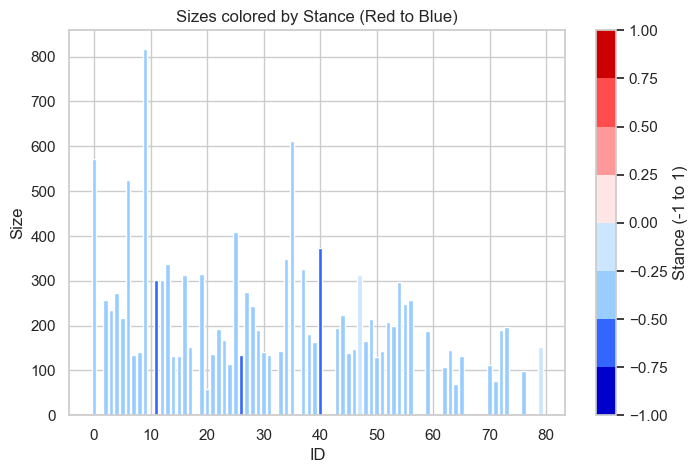

In [207]:
partition_bluesky = community_louvain.best_partition(
    Bluesky_G.to_undirected(),
    resolution=1.0
)

community_ids_bluesky = set(partition_bluesky.values())

communities_bluesky = {
    community_id: {
        node: Bluesky_G.nodes(data=True)[node] for node, comm in partition_bluesky.items()
        if comm == community_id
    }
    for community_id in community_ids_bluesky
}

communities_bluesky = {
    community_id: nodes
    for community_id, nodes in communities_bluesky.items()
    if len(nodes) > 50
}

communities_bluesky_sizes = {
    community_id: len(nodes)
    for community_id, nodes in communities_bluesky.items()
}

print(f"Communities: {len(communities_bluesky)}")

communities_leanings_bluesky = {
    community_id: np.average(
        a=[n['average_stance'] for _, n in nodes.items()],
        weights=[n['posts_count'] for _, n in nodes.items()]
    )
    for community_id, nodes in communities_bluesky.items()
}

print_communities_stance_histogram(
    communities_bluesky_sizes,
    communities_leanings_bluesky
)

In [3]:
# Information Diffusion Simulation (SIR)
# Susceptible-Infected-Recovered Model

def simulate_sir(
        graph: nx.DiGraph,
        start_node: str,
        beta: float = 0.05, # Approximation for 0.10 * <k>^-1
        gamma: float = 0.2,
) -> list[str]:
    """
    Simulates the SIR model on a directed graph.

    Parameters:
        graph (nx.DiGraph): The directed graph.
        beta (float): Infection probability per neighbor per time step.
        gamma (float): Recovery probability per infected node per time step.
        start_node (str): The starting node's ID.

    Returns:
        list of str: The list of nodes that are in the 'recovered' state at the end of the simulation
    """
    states = {node: 'S' for node in graph.nodes}
    states[start_node] = 'I'

    while True:
        new_states = states.copy()
        # Infect neighbors
        for node in graph.nodes:
            if states[node] == 'I':
                for neighbor in graph.successors(node):
                    if states[neighbor] == 'S' and random.random() < beta:
                        new_states[neighbor] = 'I' # An Infected node has a beta-chance of infecting a Susceptible neighbour

                # Recover
                if random.random() < gamma:
                    new_states[node] = 'R' # An Infected node has a gamma-chance of Recovering

        # Stop if no infection remains
        if all(state != 'I' for state in new_states.values()):
            break

        states = new_states

    return [node for node in graph.nodes if states[node] == 'R']

def average_stance(G, l) -> float:
    return float(np.average([
        G.nodes(data=True)[node]['average_stance']
        for node in l
    ]))

0/14748
1000/14748
2000/14748
3000/14748
4000/14748
5000/14748
6000/14748
7000/14748
8000/14748
9000/14748
10000/14748
11000/14748
12000/14748
13000/14748
14000/14748


C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_16264\1864350099.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


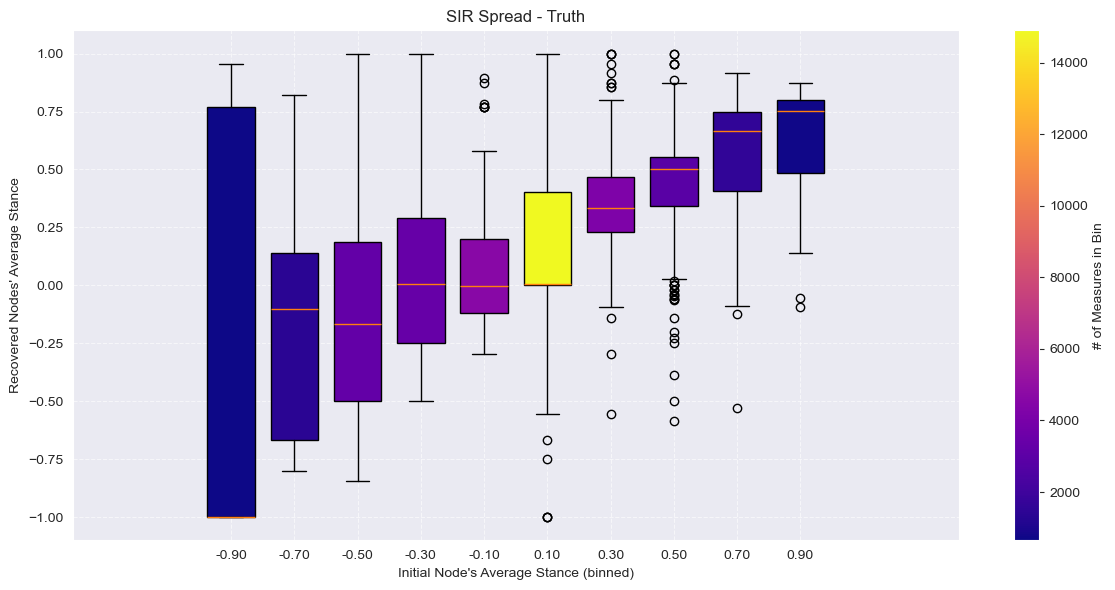

In [7]:
num_bins = 10
bin_edges = np.linspace(-1, 1, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

binned_data = defaultdict(list)
recovered_count_per_bin = defaultdict(int)

for i, (node, attr) in enumerate(Truth_G.nodes(data=True)):
    node_stance = attr['average_stance']
    bin_index = np.digitize(node_stance, bin_edges) - 1
    if 0 <= bin_index < num_bins:
        recovered = simulate_sir(Truth_G, node)
        if recovered:
            stance = average_stance(Truth_G, recovered)
            binned_data[bin_index].append(stance)
            recovered_count_per_bin[bin_index] += len(recovered)

    if i % 1000 == 0:
        print(f"{i}/{len(Truth_G.nodes)}")

# Prepare boxplot data
boxplot_data = [binned_data[i] for i in range(num_bins)]
counts = [recovered_count_per_bin[i] for i in range(num_bins)]

# Normalize counts for coloring
norm = colors.Normalize(vmin=min(counts), vmax=max(counts))
cmap = cm.get_cmap('plasma')

# Create figure and axes explicitly
fig, ax = plt.subplots(figsize=(12, 6))

# Plot boxplot
box = ax.boxplot(boxplot_data, positions=bin_centers, widths=0.15, patch_artist=True)

# Color each box based on count
for patch, count in zip(box['boxes'], counts):
    patch.set_facecolor(cmap(norm(count)))

# Add colorbar linked to this axes
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed to make colorbar work
fig.colorbar(sm, ax=ax, label="# of Measures in Bin")

# Labeling
ax.set_xlabel("Initial Node's Average Stance (binned)")
ax.set_ylabel("Recovered Nodes' Average Stance")
ax.set_title("SIR Spread - Truth")
ax.set_xticks(bin_centers)
ax.set_xticklabels([f"{x:.2f}" for x in bin_centers])
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

0/14748
1000/14748
2000/14748
3000/14748
4000/14748
5000/14748
6000/14748
7000/14748
8000/14748
9000/14748
10000/14748
11000/14748
12000/14748
13000/14748
14000/14748


C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_16264\3544110791.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


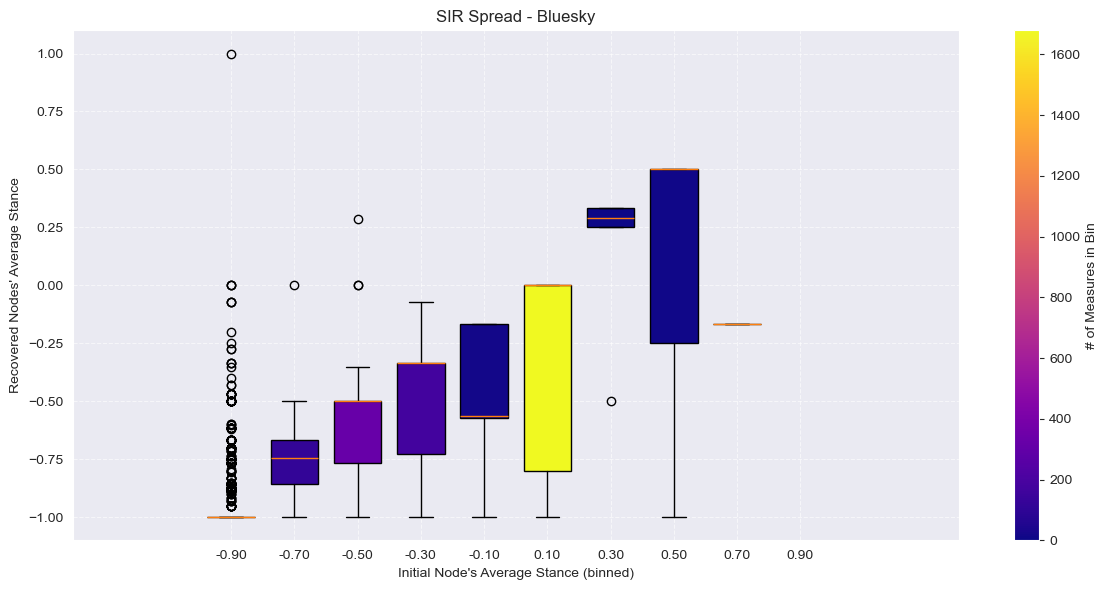

In [9]:
num_bins = 10
bin_edges = np.linspace(-1, 1, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

binned_data = defaultdict(list)
recovered_count_per_bin = defaultdict(int)

for i, (node, attr) in enumerate(Bluesky_G.nodes(data=True)):
    node_stance = attr['average_stance']
    bin_index = np.digitize(node_stance, bin_edges) - 1
    if 0 <= bin_index < num_bins:
        recovered = simulate_sir(Bluesky_G, node)
        if recovered:
            stance = average_stance(Bluesky_G, recovered)
            binned_data[bin_index].append(stance)
            recovered_count_per_bin[bin_index] += len(recovered)

    if i % 1000 == 0:
        print(f"{i}/{len(Bluesky_G.nodes)}")

# Prepare boxplot data
boxplot_data = [binned_data[i] for i in range(num_bins)]
counts = [recovered_count_per_bin[i] for i in range(num_bins)]

# Normalize counts for coloring
norm = colors.Normalize(vmin=min(counts), vmax=max(counts))
cmap = cm.get_cmap('plasma')

# Create figure and axes explicitly
fig, ax = plt.subplots(figsize=(12, 6))

# Plot boxplot
box = ax.boxplot(boxplot_data, positions=bin_centers, widths=0.15, patch_artist=True)

# Color each box based on count
for patch, count in zip(box['boxes'], counts):
    patch.set_facecolor(cmap(norm(count)))

# Add colorbar linked to this axes
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed to make colorbar work
fig.colorbar(sm, ax=ax, label="# of Measures in Bin")

# Labeling
ax.set_xlabel("Initial Node's Average Stance (binned)")
ax.set_ylabel("Recovered Nodes' Average Stance")
ax.set_title("SIR Spread - Bluesky")
ax.set_xticks(bin_centers)
ax.set_xticklabels([f"{x:.2f}" for x in bin_centers])
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()